## Diffusion Monte Carlo Method

The goal of the diffusion Monte Carlo method (DMC) is to get to the ground state wave function of a quantum system. Using the eigenstates $\psi_n$ of a system, every state can be represented as a linear combination of these eigenstates.

$$\Psi(x,0) = \sum_n c_n \psi_n(x)$$

Using the time propagation operator $U(t, t_0) = e^{-i H (t-t_0)}$, the solution for the real time Schrödinger equation reads

$$\Psi(x,t) = U(t,0)\Psi(x,0) = \sum_n c_n e^{-i E_n t / \hbar } \psi_n (x).$$

When this equation is continued into imaginary time via $t \rightarrow -i \tau$, the resulting equation

$$\Psi(x,\tau) = \sum_n c_n e^{- E_n \tau / \hbar } \psi_n (x)$$

is an exponentially damped equation with the eigenenergies $E_n$ as specific damping coefficients for the separate eigenstates. 

### Modeling Imaginary Time Propagation as Diffusion

The diffusion Monte Carlo Method uses a restated form of the Schrödinger equation as a diffusion equation to calculate the ground state wave function via a Monte Carlo process. The Schrödinger equation for a free particle in one dimension is

$$i\hbar \frac{\partial \psi (x,t)}{\partial t} = - \frac{\hbar ^2}{2m} \frac{\partial ^2 \psi (x,t)}{\partial x^2}$$

and can be rewritten as a diffusion equation 

$$\frac{\partial \psi (x,t)}{\partial t} = \frac{i \hbar ^2}{2m} \frac{\partial ^2 \psi (x,t)}{\partial x^2} = \gamma_{im} \frac{\partial ^2 \psi (x,t)}{\partial x^2},$$

where $\gamma_{im}$ is the *imaginary diffusion constant* 

$$\gamma_{im} = \frac{i \hbar ^2}{2m}.$$

In order to model the diffusion process and exploit the simulation possibilities, the imaginary diffusion constant has to be turned into a rel constant. Therefore, the operator in real time is analytically continued in imaginary time via

$$t \rightarrow i \tau,$$

leading to a diffusion equation in real space and imaginary time

$$\frac{\partial \psi (x,\tau)}{\partial \tau} = \frac{\hbar}{2m} \frac{\partial ^2 \psi (x,\tau)}{\partial x^2}.$$

We can therefore model the motion of a quantum particle in real space by simulation the diffusion of a cloud of particles in imaginary time. **//TODO: explain**

### Implementing Diffusion Monte Carlo

A diffusion monte carlo simulation for the 3-dimensional harmonic oscillator, ground state energy and wave function 

$$E_0 = \frac{2}{3}, \hspace{2em} \psi_0 = \frac{e^{-r^2/2}}{(2\pi)^{3/2}}$$

using $m=\omega=\hbar=1$

In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline

dim = 3

Potential of the harmonic oscillator in three dimensions

$$V(\mathbf x) = \frac{1}{2}\mathbf x ^2$$

In [2]:
def pot(x):
    return 0.5 * x.dot(x)

Set the time step size, the target number of walkers as well as the target number of time steps

In [3]:
dt = 0.05
N_T = 300
T_steps = 4000
alpha = 0.2

The first 20% of the time steps are used as thermalization steps, after that, the measured values are reset and the real simulation continues

In a timestep
1. Compute one DMC step on each walker
2. Remove dead walkers
3. Adjust $E_T$ to drive $N$ towards $N_T$
4. Accumulate data to measure $\left<E\right>$, its variance and the ground state wave function

In the **diffusion step**, each walker is moved randomly in the search space, in the physical picture due to the kinetic energy term. The random step is choosen from a Gaussian distribution with variance $\Delta t$.

In [4]:
def diffusion(r, dt):
    return r + random.normal(size=(r.shape[0],3)) * np.sqrt(dt)

In the **branching step**, the number of walkers is modified by the parameter $E_T$, in the physical picture due to the potential energy term. The branching is implemented by computing the branching factor $q$ via

$$q=e^{-\Delta\tau (V(x) - E_T)}$$

which then determines if a walker is cloned, survives or dies. If $q<1$, the walker dies with a probability of $1-q$. If $q > 1$, the walker is copied. 

In [5]:
def branching(r, E_T, dt):
    
    r_new = np.zeros((0,3))
    q = np.zeros((r.shape[0],))
    
    for j in range(r.shape[0]):
        
        # branching factor
        q[j] = np.exp(-dt * (pot(r[j,:]) - E_T))
        
        # branching
        if q[j] - int(q[j]) > random.uniform():
            count_new = int(q[j]) + 1
        else:
            count_new = int(q[j])
            
        # generate new walker array
        for c in range(count_new):
            r_new = np.append(r_new,r[j:j+1,:],axis=0)
            
    return r_new, r_new.shape[0]

In the **adjustment step**, the value of $E_T$ is adjusted to drive the number of walkers towards the desired number $N_T$. If $N > N_T$, the number of walkers is too high. We therefore increase $E_T$, reducing $q$ and the number of walkers. If, on the other hand, $N < N_T$, walkers need to be created. Then, $E_T$ is decreased, increasing $q$ as well as the number of walkers. The factor $\alpha$ controls the rate of change and has to be adjusted according to the simulation settings.

$$E_T \rightarrow E_T + \alpha \ln \left( \frac{N_T}{N} \right)$$

In [6]:
def adjust(N_T, N):
    return alpha * np.log(N_T / float(N))

During each step of the production phase, the data is **accumulated** to evaluate the energy, energy variance and wave function $\psi$.

In [12]:
class Accumulator(object):
    def __init__(self):
        self.E_sum = 0
        self.E_squared_sum = 0
        self.r_max = 4.0
        self.N_psi = 100
        self.psi = np.zeros((self.N_psi,))
        
    def reset(self):
        self.E_sum = 0
        self.E_squared_sum = 0
        self.psi = np.zeros((self.N_psi,))
        
    def handle_data(self, E_T, r):
        self.E_sum += E_T
        self.E_squared_sum += E_T**2
    
        for j in range(r.shape[0]):
            r_squared = r[j,:].dot(r[j,:])
            i_bin = int(np.sqrt(r_squared) / self.r_max * self.N_psi)
            if i_bin < self.N_psi:
                self.psi[i_bin] += 1

In [13]:
# Initialize walkers
r = np.zeros((N_T, 3))
N = N_T
E_T = 0 # initial guess for the ground state energy

thermal_steps = int(0.2*T_steps)

acc = Accumulator()

# Time step
for i in range(thermal_steps+T_steps):
    # Diffusion step
    r = diffusion(r, dt)
    
    # Branching step
    r, N = branching(r, E_T, dt)
    
    # Adjustment
    E_T += adjust(N_T, N)
    
    # Accumulation
    if i == thermal_steps:
        acc.reset()   
    acc.handle_data(E_T, r)

In [14]:
E_avg = acc.E_sum/T_steps
E_var = acc.E_squared_sum/T_steps - E_avg**2

print E_avg
print E_var
print acc.psi

1.49951719539
2.3538065088
[  3.00000000e+01   1.76000000e+02   5.40000000e+02   9.94000000e+02
   1.65400000e+03   2.49000000e+03   3.47100000e+03   4.47500000e+03
   5.72900000e+03   7.10900000e+03   8.37300000e+03   9.92700000e+03
   1.16070000e+04   1.30880000e+04   1.47570000e+04   1.65980000e+04
   1.81250000e+04   1.99200000e+04   2.17630000e+04   2.33340000e+04
   2.48960000e+04   2.63790000e+04   2.80580000e+04   2.95910000e+04
   3.07790000e+04   3.23110000e+04   3.30980000e+04   3.40750000e+04
   3.52150000e+04   3.57810000e+04   3.68720000e+04   3.69170000e+04
   3.73590000e+04   3.77020000e+04   3.80420000e+04   3.80870000e+04
   3.78090000e+04   3.74840000e+04   3.78460000e+04   3.66360000e+04
   3.64260000e+04   3.60240000e+04   3.49670000e+04   3.43890000e+04
   3.33940000e+04   3.23210000e+04   3.14250000e+04   3.02350000e+04
   2.93800000e+04   2.84560000e+04   2.71830000e+04   2.59810000e+04
   2.44080000e+04   2.34970000e+04   2.28360000e+04   2.13980000e+04
   1.99

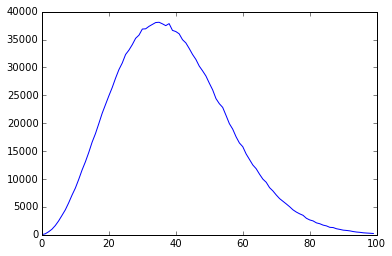

In [15]:
plt.plot(acc.psi)
plt.show()

# Diffusion Monte Carlo for Optimization